In [1]:
# 필요한 패키지 설치
%pip install --upgrade google-api-python-client
%pip install --upgrade google-auth-oauthlib google-auth-httplib2
%pip install oauth2client
%pip install numpy
%pip install pandas
%pip install selenium
%pip install matplotlib
%pip install pyplot

# 라이브러리 추가
%pip install --upgrade google-api-python-client
%pip install --upgrade google-auth google-auth-oauthlib google-auth-httplib2
%pip install tabulate
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
# 시스템 관련 모듈
import os
import sys
import time
import re

# 유튜브 API 모듈
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.tools import argparser

# 데이터 분석 모듈
import numpy as np
import pandas as pd

# 크롤링 관련 모듈
from selenium import webdriver as wd
from selenium.webdriver.common.by import By

# 시각화 관련 모듈
import site; site.getsitepackages()
from konlpy.tag import Mecab
from ast import increment_lineno
from matplotlib import pyplot as plt
# 차트를 주피터 노트북에 삽입하는 매직코드(코랩은 생략 가능)
%matplotlib inline
# 코랩은 차트에 한글이 깨진다. => 폰트가 없다. -> 폰트를 설치 후 사용가능(매번 인스턴스 생성할때마다 반복)
import matplotlib
import seaborn as sns

# 유튜브 Analytics API 관련 모델 추가

import google.oauth2.credentials
import google_auth_oauthlib.flow
from google_auth_oauthlib.flow import InstalledAppFlow
from tabulate import tabulate

# 셀레니움을 이용한 플레이리스트 싫어요 수 뽑기

In [41]:
driver = wd.Chrome(
    './chromedriver/chromedriver.exe')

C:\Users\Marker\AppData\Local\Temp\ipykernel_9048\3570440997.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = wd.Chrome(


In [ ]:

playlist_link = 'PLNt6TwFqolR1qeYbB3j8wIdmzKPUXXPUo'
playlist_index = 1
target_site = f'https://www.youtube.com/watch?v=6DMH3ZHAe5o&list={playlist_link}&index={playlist_index}'
driver.get( target_site )

In [ ]:
# 게시물별 단위 조사
videos = driver.find_elements(By.CSS_SELECTOR,'#segmented-dislike-button > ytd-toggle-button-renderer > yt-button-shape > button')

print(videos)

[<selenium.webdriver.remote.webelement.WebElement (session="118104bf2a8313d8552f0483681e94de", element="d94b461f-2322-44e4-a2ff-a839f1943fed")>, <selenium.webdriver.remote.webelement.WebElement (session="118104bf2a8313d8552f0483681e94de", element="0975cea2-955d-43c2-878e-af15b75dc029")>]


In [ ]:
playlist_links = driver.find_elements(By.CSS_SELECTOR,'#wc-endpoint')
video_hash = driver.find_element(By.ID,'super-title')

In [ ]:
# 게시물 리스트에서 데이터를 하나씩 뽑은 후 그 위치에 해당하는 영상 클릭
# 5초 후 타이틀, 싫어요, 해시태그 뽑고 dislike 리스트에 append
# 사용 시 https://chrome.google.com/webstore/detail/return-youtube-dislike/gebbhagfogifgggkldgodflihgfeippi 확장앱 설치 필요.
dislike = list()
for t in range(len(playlist_links)) :
    playlist_link = playlist_links.pop( )
    playlist_link.click()
    time.sleep(5)
    dislike.append({
        'title' : driver.find_element(By.CSS_SELECTOR,'#title > h1 > yt-formatted-string').text,
        'dislikes' : videos[0].find_element(By.CSS_SELECTOR,'#text').text,
        'hashtag' : video_hash.text
    })



In [ ]:
# 데이터 프레임 생성

df = pd.DataFrame(dislike)

In [ ]:
# CSV 파일 변환

df.to_csv('탑현.csv', index=False, encoding='utf-8-sig')

# Youtube Analytics API

In [49]:
SCOPES = ["https://www.googleapis.com/auth/youtube.readonly",
  "https://www.googleapis.com/auth/yt-analytics.readonly"]

API_SERVICE_NAME = 'youtubeAnalytics'
API_VERSION = 'v2'
CLIENT_SECRETS_FILE = './client_secret/client_secret_333676912599-mouued5pr786ujj58svanio8nb706a8i.apps.googleusercontent.com.json'
def get_service():
  flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
  credentials = flow.run_local_server()
  return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

def execute_api_request(client_library_function, **kwargs):
  response = client_library_function(
    **kwargs
  ).execute()
  return response

def create_table(table, headers=None):
    if headers:
        headerstring = "\t{}\t" * len(headers)
        print(headerstring.format(*headers))

    rowstring = "\t{}\t" * len(table[0])

    for row in table:
        print(rowstring.format(*row))


if __name__ == '__main__':

    youtubeAnalytics = get_service()
    result = execute_api_request(
        youtubeAnalytics.reports().query,
        ids='channel==MINE',
        startDate='2022-04-01',
        endDate='2022-12-31',
        metrics='estimatedMinutesWatched,views,likes,subscribersGained',
        dimensions='day',
        sort='day'
    )
    headers = ['date', 'estMinutesWatched', 'views', 'likes', 'subscribersGained']
    # create_table(result['rows'], headers=headers)
    print(tabulate(result['rows'], headers=headers, tablefmt="pretty"))
    
    # print(result)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=333676912599-mouued5pr786ujj58svanio8nb706a8i.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyt-analytics.readonly&state=b2aL791xf1vEltQg5Sp7iy7vPCqPdP&access_type=offline
+------------+-------------------+-------+-------+-------------------+
|    date    | estMinutesWatched | views | likes | subscribersGained |
+------------+-------------------+-------+-------+-------------------+
| 2022-04-01 |         1         |   4   |   0   |         0         |
| 2022-04-02 |         1         |   2   |   1   |         0         |
| 2022-04-03 |         1         |   7   |   0   |         0         |
| 2022-04-04 |        47         |  20   |  12   |         1         |
| 2022-04-05 |         0         |   3   |   0   |         0         |
| 2

In [47]:
SCOPES = ['https://www.googleapis.com/auth/yt-analytics.readonly']

API_SERVICE_NAME = 'youtubeAnalytics'
API_VERSION = 'v2'
CLIENT_SECRETS_FILE = './client_secret/client_secret_333676912599-mouued5pr786ujj58svanio8nb706a8i.apps.googleusercontent.com.json'
def get_service():
  flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
  credentials = flow.run_local_server()
  return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

def execute_api_request(client_library_function, **kwargs):
  response = client_library_function(
    **kwargs
  ).execute()
  return response

def create_table(table, headers=None):
    if headers:
        headerstring = "\t{}\t" * len(headers)
        print(headerstring.format(*headers))

    rowstring = "\t{}\t" * len(table[0])

    for row in table:
        print(rowstring.format(*row))

if __name__ == '__main__':
  # Disable OAuthlib's HTTPs verification when running locally.
  # *DO NOT* leave this option enabled when running in production.
  os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'

  youtubeAnalytics = get_service()
  result = execute_api_request(
      youtubeAnalytics.reports().query,
      ids='channel==MINE',
      startDate='2022-02-16',
      endDate='2023-01-16',
      metrics='estimatedMinutesWatched,views,likes,subscribersGained',
      dimensions='day',
      sort='day'
  )

print(result, type(result))


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=333676912599-mouued5pr786ujj58svanio8nb706a8i.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyt-analytics.readonly&state=azdSnUYdeOWh7chHFHhCtC5VTbamMl&access_type=offline
{'kind': 'youtubeAnalytics#resultTable', 'columnHeaders': [{'name': 'day', 'columnType': 'DIMENSION', 'dataType': 'STRING'}, {'name': 'estimatedMinutesWatched', 'columnType': 'METRIC', 'dataType': 'INTEGER'}, {'name': 'views', 'columnType': 'METRIC', 'dataType': 'INTEGER'}, {'name': 'likes', 'columnType': 'METRIC', 'dataType': 'INTEGER'}, {'name': 'subscribersGained', 'columnType': 'METRIC', 'dataType': 'INTEGER'}], 'rows': [['2022-02-16', 7, 4, 1, 4], ['2022-02-17', 0, 1, 0, 0], ['2022-02-18', 0, 3, 1, 1], ['2022-02-19', 6, 4, 1, 0], ['2022-02-20', 37, 17, 4, 1], ['2022-02-21', 4, 3, 0, 0], ['2022-02-22', 10, 6, 0, 0], ['

In [ ]:
# 필요한 데이터 확인

result['rows']

[['2022-02-16', 7, 4, 1, 4],
 ['2022-02-17', 0, 1, 0, 0],
 ['2022-02-18', 0, 3, 1, 1],
 ['2022-02-19', 6, 4, 1, 0],
 ['2022-02-20', 37, 17, 4, 1],
 ['2022-02-21', 4, 3, 0, 0],
 ['2022-02-22', 10, 6, 0, 0],
 ['2022-02-23', 7, 6, 0, 0],
 ['2022-02-24', 5, 6, 0, 0],
 ['2022-02-25', 0, 0, 0, 0],
 ['2022-02-26', 4, 7, 0, 0],
 ['2022-02-27', 0, 0, 0, 0],
 ['2022-02-28', 11, 18, 2, 0],
 ['2022-03-01', 9, 10, 0, 0],
 ['2022-03-02', 2, 3, 0, 0],
 ['2022-03-03', 1, 2, 0, 0],
 ['2022-03-04', 4, 8, 0, 1],
 ['2022-03-05', 0, 0, 0, 0],
 ['2022-03-06', 0, 1, 0, 0],
 ['2022-03-07', 15, 12, 2, 1],
 ['2022-03-08', 15, 8, 0, 0],
 ['2022-03-09', 0, 1, 0, 0],
 ['2022-03-10', 6, 4, 1, 0],
 ['2022-03-11', 0, 2, 0, 0],
 ['2022-03-12', 6, 4, 0, 0],
 ['2022-03-13', 5, 4, 1, 0],
 ['2022-03-14', 20, 18, 3, 0],
 ['2022-03-15', 0, 0, 0, 0],
 ['2022-03-16', 4, 2, 0, 0],
 ['2022-03-17', 0, 1, 0, 0],
 ['2022-03-18', 2, 3, 0, 0],
 ['2022-03-19', 3, 2, 0, 0],
 ['2022-03-20', 0, 1, 0, 0],
 ['2022-03-21', 21, 16, 3, 0],
 

In [50]:
# 데이터 정제

kkakka_data_cols = ['estimatedMinutesWatched','views','likes','subscribersGained']
kkakka_data_index = [] 
kkakka_data_data = []
for i in range(len(result['rows'])):
    kkakka_data_index.append(result['rows'][i][0])
    kkakka_data_data.append(result['rows'][i][1:])

In [51]:
# 본인 유튜브 일별 데이터 출력

kkakka_data_df = pd.DataFrame(kkakka_data_data, kkakka_data_index, kkakka_data_cols)
kkakka_data_df

,estimatedMinutesWatched,views,likes,subscribersGained
2022-04-01,1,4,0,0
2022-04-02,1,2,1,0
2022-04-03,1,7,0,0
2022-04-04,47,20,12,1
2022-04-05,0,3,0,0
...,...,...,...,...
2022-12-27,126,61,5,0
2022-12-28,173,90,0,0
2022-12-29,112,56,2,0
2022-12-30,90,51,0,1


# Kaggle 데이터 분석

In [4]:
# 데이터 불러오기 및 출력

KRvideo = pd.read_csv("KR_youtube_trending_data.csv")
KRvideo.tail()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
175149,OSjuuTM-Raw,'내장 냄새로 풀풀' 잡은 즉시 내장을 꺼내 미끼로 쓰는 대왕오징어 잡이│조업에서 ...,2023-01-04T06:53:07Z,UCFCtZJTuJhE18k8IXwmXTYQ,EBSDocumentary (EBS 다큐),25,2023-01-15T00:00:00Z,EBS|EBS documentary|EBS 다큐멘터리|다큐|docu|대왕오징어|오징...,1304086,4893,0,488,https://i.ytimg.com/vi/OSjuuTM-Raw/default.jpg,False,False,※ 이 영상은 2022년 12월 21일에 방송된 ＜인간과 바다 - 태평양의 거대한 ...
175150,h-k2PcfFDwk,aespa 에스파 'Girls' Stage Video,2023-01-01T13:01:41Z,UC9GtSLeksfK4yuJ_g1lgQbg,aespa,10,2023-01-15T00:00:00Z,aespa|에스파|Girls|카리나|지젤|윈터|닝닝|퍼포먼스|무대|안무|댄스|kar...,1980595,92028,0,2585,https://i.ytimg.com/vi/h-k2PcfFDwk/default.jpg,False,False,From SMTOWN LIVE 2023 : SMCU PALACE @KWANGYA🏰 ...
175151,bHSYy5elYDk,새해 첫 날 일본 가정집의 하루 브이로그,2023-01-03T02:22:09Z,UCaJCF6bmhG2wqPF3jA9gS4w,유우키의 일본이야기 YUUKI,22,2023-01-15T00:00:00Z,[None],912832,21570,0,2281,https://i.ytimg.com/vi/bHSYy5elYDk/default.jpg,False,False,냐옹
175152,wwKRaMu0pUE,(SUB) 이나연 탈탈털기 Q&A,2023-01-06T07:00:47Z,UCbFbzOHmp04AS2ZkFSpQ4Og,일단이나연 NAYEON,22,2023-01-15T00:00:00Z,[None],731664,13234,0,945,https://i.ytimg.com/vi/wwKRaMu0pUE/default.jpg,False,False,안녕하세요🙈 이번주는 큐앤에이로 찾아왔습니다...ㅎㅎ 궁금하신 점을 정말 많이 남겨...
175153,uJocp_7wuY8,우리나라에서 가장 오래된 100년 된 문방구를 찾았습니다!!!,2023-01-04T08:45:17Z,UCk6bX-MZXdte_7kG8TbMkqg,허팝Heopop,24,2023-01-15T00:00:00Z,허팝|heopop|gjvkq|stationery store|문방구|우리나라|대한민국...,638611,7366,0,784,https://i.ytimg.com/vi/uJocp_7wuY8/default.jpg,False,False,엄청난 역사를 자랑하는 100년된 문방구!!! 점점 문방구가 사라져가는 이 시점에 ...


In [5]:
# 컬럼명 기준으로 데이터 정제

df = pd.read_csv("KR_youtube_trending_data.csv")
KRvideo = df[['title', 'channelTitle', 'tags', 'publishedAt', 'trending_date', 'categoryId', 'view_count', 'likes', 'comment_count']]
KRvideo.tail()

,title,channelTitle,tags,publishedAt,trending_date,categoryId,view_count,likes,comment_count
175149,'내장 냄새로 풀풀' 잡은 즉시 내장을 꺼내 미끼로 쓰는 대왕오징어 잡이│조업에서 ...,EBSDocumentary (EBS 다큐),EBS|EBS documentary|EBS 다큐멘터리|다큐|docu|대왕오징어|오징...,2023-01-04T06:53:07Z,2023-01-15T00:00:00Z,25,1304086,4893,488
175150,aespa 에스파 'Girls' Stage Video,aespa,aespa|에스파|Girls|카리나|지젤|윈터|닝닝|퍼포먼스|무대|안무|댄스|kar...,2023-01-01T13:01:41Z,2023-01-15T00:00:00Z,10,1980595,92028,2585
175151,새해 첫 날 일본 가정집의 하루 브이로그,유우키의 일본이야기 YUUKI,[None],2023-01-03T02:22:09Z,2023-01-15T00:00:00Z,22,912832,21570,2281
175152,(SUB) 이나연 탈탈털기 Q&A,일단이나연 NAYEON,[None],2023-01-06T07:00:47Z,2023-01-15T00:00:00Z,22,731664,13234,945
175153,우리나라에서 가장 오래된 100년 된 문방구를 찾았습니다!!!,허팝Heopop,허팝|heopop|gjvkq|stationery store|문방구|우리나라|대한민국...,2023-01-04T08:45:17Z,2023-01-15T00:00:00Z,24,638611,7366,784


In [6]:
# 업로드된 날짜와 음악 카테고리를 기준으로 데이터 정제

KRvideo_set = (KRvideo['publishedAt'] >= '2022-01-01') & (KRvideo['publishedAt'] <= '2023-01-01') & (KRvideo['categoryId'] == 10)

KRvideo_set_filtered = KRvideo.loc[KRvideo_set].reset_index(drop=True).drop_duplicates(['publishedAt'])

KRvideo_set_filtered

,title,channelTitle,tags,publishedAt,trending_date,categoryId,view_count,likes,comment_count
0,[가요대제전 4K 직캠] 임윤아&이준호 'Señorita' (YOONA&JUNHO ...,MBCkpop,mbc|KPOP|dance|song|korea|korean|show|music co...,2022-01-01T04:01:41Z,2022-01-02T00:00:00Z,10,1027280,29062,1168
1,[옷소매 붉은 끝동 OST] 이선희 - 그대 손 놓아요 (녹음실 풀버전),TOON STUDIO,#TOONSTUDIO|툰스튜디오|웹툰|ost,2022-01-01T09:00:08Z,2022-01-02T00:00:00Z,10,134425,6213,479
2,WOOZI ‘Ruby’ Official Teaser,HYBE LABELS,HYBE|HYBE LABELS|하이브|하이브레이블즈,2022-01-01T14:59:57Z,2022-01-02T00:00:00Z,10,632144,134607,5317
6,WOOZI 'Ruby' Official MV,HYBE LABELS,HYBE|HYBE LABELS|하이브|하이브레이블즈,2022-01-03T08:59:58Z,2022-01-04T00:00:00Z,10,2153099,405146,25110
7,Step Back,Various Artists - Topic,GOT the beat|Step Back,2022-01-03T09:05:47Z,2022-01-04T00:00:00Z,10,356600,9335,0
...,...,...,...,...,...,...,...,...,...
8393,가족사진 느낌으로 갈까?📸✨ | 도재정’s PHOTO STUDIO🎄,NCT,nct|nct127|엔시티|엔시티127|cover|커버|도영|재현|정우|도재정|크리...,2022-12-25T05:00:07Z,2022-12-31T00:00:00Z,10,354695,32492,1064
8416,YG NEXT MOVEMENT,YG ENTERTAINMENT,YG Entertainment|YG 와이지|케이팝|K pop|K-pop,2022-12-31T15:00:42Z,2023-01-01T00:00:00Z,10,3922444,389403,23505
8418,NewJeans (뉴진스) 'Ditto' Performance Video (Fix ...,NewJeans,NewJeans|뉴진스|민지|하니|다니엘|해린|혜인|뉴진스 민지|뉴진스 하니|뉴진스...,2022-12-31T08:00:01Z,2023-01-01T00:00:00Z,10,840289,58089,1397
8445,[가요대제전] JEONG DONG WON - Baennori(정동원 – 뱃놀이) F...,MBCkpop,mbc|KPOP|dance|song|korea|korean|show|music co...,2022-12-31T16:16:00Z,2023-01-02T00:00:00Z,10,215364,9074,1309


In [68]:
# 자료 확인

display(KRvideo_set_filtered.info(), KRvideo_set_filtered.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 8474
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          822 non-null    object
 1   channelTitle   822 non-null    object
 2   tags           822 non-null    object
 3   publishedAt    822 non-null    object
 4   trending_date  822 non-null    object
 5   categoryId     822 non-null    int64 
 6   view_count     822 non-null    int64 
 7   likes          822 non-null    int64 
 8   comment_count  822 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 64.2+ KB


None

(822, 9)

# 시각화

In [ ]:
# mecab 테스트

m = Mecab(dicpath="C:/mecab/mecab-ko-dic") # 사전 저장 경로에 자신이 mecab-ko-dic를 저장한 위치를 적는다. (default: "/usr/local/lib/mecab/dic/mecab-ko-dic")
m.pos("안녕하세요")

[('안녕', 'NNG'), ('하', 'XSV'), ('세요', 'EP+EF')]

In [53]:
# 기초통계량 확인

pd.options.display.float_format = '{:.2f}'.format # 소수점 둘째자리까지 확인
KRvideo_set_filtered.describe()

# 좋아요, 댓글 수가 0개인 경우, 크리에이터 본인이 표시를 안하게 한 경우이다.

,categoryId,view_count,likes,comment_count
count,822.00,822.00,822.00,822.00
mean,10.00,2121499.69,215420.52,17102.06
std,0.00,4755513.29,478487.97,68142.27
min,10.00,54767.00,0.00,0.00
25%,10.00,256172.25,14782.50,1003.25
50%,10.00,555813.00,54327.00,2769.50
75%,10.00,1641843.25,155788.50,7336.00
max,10.00,45176630.00,4309966.00,1077229.00


<Figure size 1000x500 with 0 Axes>

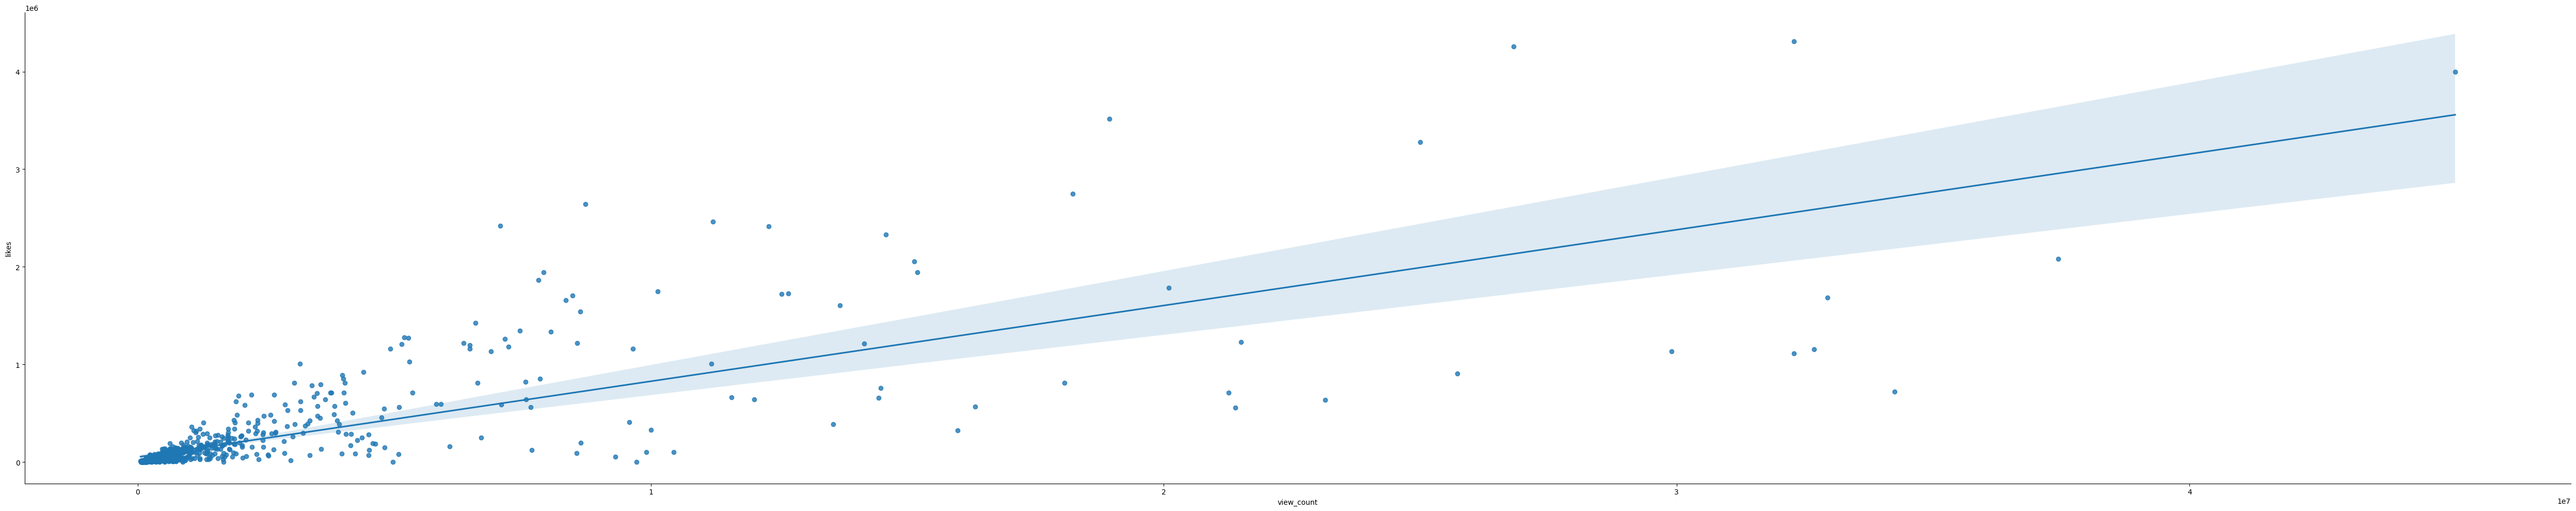

In [67]:
plt.figure(figsize=(10,5))
sns.lmplot(x='view_count', y='likes', data=KRvideo_set_filtered, height=10, aspect=5) 
plt.show()

# 해석
# 인기 급상승 동영상의 경우, 조회수에 비레해서 좋아요 수가 높다는 걸 알 수 있다.
# 하지만, 각 영상마다 편차가 굉장히 커서 자료로는 부적합하다.

In [84]:
KRvideo_set_filtered[KRvideo_set_filtered['channelTitle'] == '성시경 SUNG SI KYUNG']

,title,channelTitle,tags,publishedAt,trending_date,categoryId,view_count,likes,comment_count
356,[성시경 노래] 18. 사랑이 늦어서 미안해 (With.김조한) l Sung Si ...,성시경 SUNG SI KYUNG,성시경|성시경유튜브|SUNGSIKYUNG|SSK|ソンシギョン|成始璄|성시경 음악|성...,2022-02-03T03:00:16Z,2022-02-04T00:00:00Z,10,106875,8836,1269
420,[성시경 노래] 19. 한번 더 이별 l Sung Si Kyung Music,성시경 SUNG SI KYUNG,성시경|성시경유튜브|SUNGSIKYUNG|SSK|ソンシギョン|成始璄|성시경 음악|성...,2022-02-07T03:00:08Z,2022-02-08T00:00:00Z,10,122731,9556,1217
526,[성시경 노래] 21. 희재 l Sung Si Kyung Music,성시경 SUNG SI KYUNG,성시경|성시경유튜브|SUNGSIKYUNG|SSK|ソンシギョン|成始璄|성시경 음악|성...,2022-02-14T03:00:11Z,2022-02-15T00:00:00Z,10,204228,14967,1709
828,[성시경 노래] 26. 나였으면 (With.나윤권) l Sung Si Kyung M...,성시경 SUNG SI KYUNG,성시경|성시경유튜브|SUNGSIKYUNG|SSK|ソンシギョン|成始璄|성시경 음악|성...,2022-03-03T03:00:10Z,2022-03-03T00:00:00Z,10,80960,10472,1202


C:\Users\Marker\AppData\Local\Temp\ipykernel_32760\636862252.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = KRvideo_set_filtered.corr()


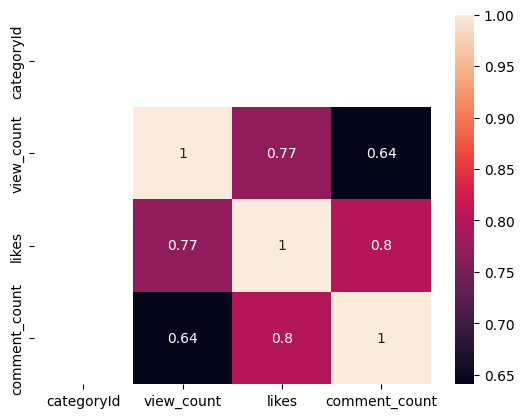

In [7]:
corr = KRvideo_set_filtered.corr()
sns.heatmap(corr, annot=True)
plt.show()